In [1]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # experiment path
# visible GPUs
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [9]:
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image

import SimpleITK as sitk
from tqdm import tqdm
from IPython.display import clear_output
import shutil
import matplotlib.pyplot as plt

In [10]:
def registrater_affine(fixed:sitk.Image, moving:sitk.Image, show=False):
    """registration of two sitk images using affine transformation

    Args:
        fixed (sitk.Image): fixed image. In CEDM SET, it is the image with contrast enhancement
        moving (sitk.Image): moving image, in CEDM is the image before contrast injection

    Returns:
        sitk.ParameterMap: transform parameters
    """
    # register
    parameterMap = sitk.GetDefaultParameterMap('affine')
    parameterMap['NumberOfSpatialSamples'] = ['5000']
    #run registration
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed)
    elastixImageFilter.SetMovingImage(moving)
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()
    moved_im = elastixImageFilter.GetResultImage()
    #save transform parameters
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()

    clear_output(wait=show)

    return transformParameterMap, moved_im

The idea of the bridge is to generate high quality Mammo2CEm images training our pipeline using patches of the TRAINING images.<br>
The patches will be 512x512.

In [11]:
train_metadata_path = repo_path / 'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
im_dir_CEM = repo_path / 'data/CDD-CESM/images/substracted'
im_dir_low = repo_path / 'data/CDD-CESM/images/low-energy'
train_metadata = pd.read_csv(train_metadata_path)

# saving dir
save_dir = repo_path / 'generation/bbridge/data/CEM-512/split_1/train'
save_dir.mkdir(parents=True, exist_ok=True)

In [39]:
for image_name in tqdm(train_metadata['image_name'].unique()):
    print(image_name)

100%|██████████| 187/187 [00:00<00:00, 75070.33it/s]

P2_R_CM_CC
P2_R_CM_MLO
P3_L_CM_CC
P3_L_CM_MLO
P6_L_CM_MLO
P7_L_CM_MLO
P11_R_CM_CC
P11_R_CM_MLO
P16_R_CM_MLO
P24_R_CM_CC
P24_R_CM_MLO
P38_R_CM_CC
P38_R_CM_MLO
P55_R_CM_CC
P55_R_CM_MLO
P56_L_CM_MLO
P59_R_CM_CC
P59_R_CM_MLO
P61_L_CM_CC
P61_L_CM_MLO
P64_R_CM_CC
P65_L_CM_CC
P65_L_CM_MLO
P66_R_CM_CC
P66_R_CM_MLO
P66_L_CM_CC
P66_L_CM_MLO
P72_R_CM_CC
P82_L_CM_CC
P82_L_CM_MLO
P93_L_CM_CC
P93_L_CM_MLO
P94_R_CM_CC
P94_R_CM_MLO
P95_L_CM_CC
P99_R_CM_CC
P99_R_CM_MLO
P102_R_CM_CC
P102_R_CM_MLO
P111_R_CM_MLO
P116_R_CM_CC
P116_R_CM_MLO
P119_L_CM_CC
P119_L_CM_MLO
P122_R_CM_CC
P122_R_CM_MLO
P122_L_CM_CC
P122_L_CM_MLO
P123_R_CM_CC
P123_R_CM_MLO
P126_L_CM_CC
P126_L_CM_MLO
P129_L_CM_CC
P129_L_CM_MLO
P132_R_CM_MLO
P134_R_CM_MLO
P146_R_CM_CC
P146_R_CM_MLO
P152_L_CM_CC
P152_L_CM_MLO
P155_L_CM_CC
P155_L_CM_MLO
P161_L_CM_CC
P161_L_CM_MLO
P173_L_CM_MLO
P177_R_CM_CC
P177_R_CM_MLO
P177_L_CM_CC
P177_L_CM_MLO
P183_L_CM_CC
P183_L_CM_MLO
P188_R_CM_CC
P188_R_CM_MLO
P190_L_CM_CC
P190_L_CM_MLO
P191_L_CM_CC
P191_L_CM_MLO
P

In [37]:
ex_im_path = im_dir_CEM / (train_metadata['image_name'][20] + '.jpg')
low_im_path = im_dir_low / (ex_im_path.stem.replace('CM', 'DM') + '.jpg')

# read the image
ex_im = cv.imread(str(ex_im_path), cv.IMREAD_GRAYSCALE)
low_im = cv.imread(str(low_im_path), cv.IMREAD_GRAYSCALE)
print(f'image shapes: {ex_im.shape}, {low_im.shape}')

# register images
fixedImage = sitk.GetImageFromArray(ex_im)
movingImage = sitk.GetImageFromArray(low_im)
_, moved_im = registrater_affine(fixedImage, movingImage, show=False)
low_im = sitk.GetArrayFromImage(moved_im)

print(f'Shape after registration: {ex_im.shape}, {low_im.shape}')

Shape after registration: (2620, 1657), (2620, 1657)


In [38]:
# create a subimage of 512x512, starting from the 0,0 corner
for i_y in range(len(ex_im)//512):
    for i_x in range(len(ex_im[0])//512):
        y_shift = 512*i_y
        x_shift = 512*i_x

        from_y = 0+y_shift
        to_y = 512+y_shift
        from_x = 0+x_shift
        to_x = 512+x_shift

        if to_y > ex_im.shape[0]: # when to_y is too large (end of image)
            to_complete_y = 512 - (ex_im.shape[0] - from_y)
            to_y = ex_im.shape[0]

            sub_im = np.zeros((512, 512), dtype=np.uint8)
            # fill the subimage with the original image
            sub_im[:to_y-from_y, :] = ex_im[from_y:to_y, from_x:to_x]
            # replicate for low energy image
            sub_low_im = np.zeros((512, 512), dtype=np.uint8)
            sub_low_im[:to_y-from_y, :] = low_im[from_y:to_y, from_x:to_x]
        elif to_x > ex_im.shape[1]:
            to_complete_x = 512 - (ex_im.shape[1] - from_x)
            to_x = ex_im.shape[1]

            sub_im = np.zeros((512, 512), dtype=np.uint8)
            # fill the subimage with the original image
            sub_im[:, :to_x-from_x] = ex_im[from_y:to_y, from_x:to_x]
            # replicate for low energy image
            sub_low_im = np.zeros((512, 512), dtype=np.uint8)
            sub_low_im[:, :to_x-from_x] = low_im[from_y:to_y, from_x:to_x]

        else: # when limits are within the image
            sub_im = ex_im[from_y:to_y, from_x:to_x]
            sub_low_im = low_im[from_y:to_y, from_x:to_x]

        # if more than 30% of the image is black, then the image is considered black
        black = np.sum(sub_im == 0) / (512*512) > 0.7
        sub_im = Image.fromarray(sub_im)
        sub_low_im = Image.fromarray(sub_low_im).convert('L')
        print(f'Image from y:{from_y} to y:{to_y} and x:{from_x} to x:{to_x} is black: {black}')

        # #### register images
        # fixedImage = sitk.GetImageFromArray(np.array(sub_im))
        # movingImage = sitk.GetImageFromArray(np.array(sub_low_im))
        # _, moved_im = registrater_affine(fixedImage, movingImage, show=False)
        # sub_low_im = Image.fromarray(sitk.GetArrayFromImage(moved_im)).convert('L')
        # #####

        # save image in the save_dir
        save_path = save_dir / 'B' / f'{ex_im_path.stem}_y{i_y}_x{i_x}.jpg'
        save_path.parent.mkdir(parents=True, exist_ok=True)
        sub_im.save(save_path)

        save_path_low = save_dir / 'A' / f'{low_im_path.stem}_y{i_y}_x{i_x}.jpg'
        save_path_low.parent.mkdir(parents=True, exist_ok=True)
        sub_low_im.save(save_path_low)


Image from y:0 to y:512 and x:0 to x:512 is black: False
Image from y:0 to y:512 and x:512 to x:1024 is black: False
Image from y:0 to y:512 and x:1024 to x:1536 is black: True
Image from y:512 to y:1024 and x:0 to x:512 is black: False
Image from y:512 to y:1024 and x:512 to x:1024 is black: False
Image from y:512 to y:1024 and x:1024 to x:1536 is black: False
Image from y:1024 to y:1536 and x:0 to x:512 is black: False
Image from y:1024 to y:1536 and x:512 to x:1024 is black: False
Image from y:1024 to y:1536 and x:1024 to x:1536 is black: False
Image from y:1536 to y:2048 and x:0 to x:512 is black: False
Image from y:1536 to y:2048 and x:512 to x:1024 is black: False
Image from y:1536 to y:2048 and x:1024 to x:1536 is black: False
Image from y:2048 to y:2560 and x:0 to x:512 is black: False
Image from y:2048 to y:2560 and x:512 to x:1024 is black: False
Image from y:2048 to y:2560 and x:1024 to x:1536 is black: False


# Registration

In [30]:
#define fixed and moving
fixedImage = sitk.GetImageFromArray(ex_im)
movingImage = sitk.GetImageFromArray(low_im)

transformParameterMap, moved_im = registrater_affine(fixedImage, movingImage, show=False)
# # move created files radiomics/TransformParameters.0.txt to data
# shutil.move('TransformParameters.0.txt', repo_path / f'data/registration/transform_{pat_num}.txt')

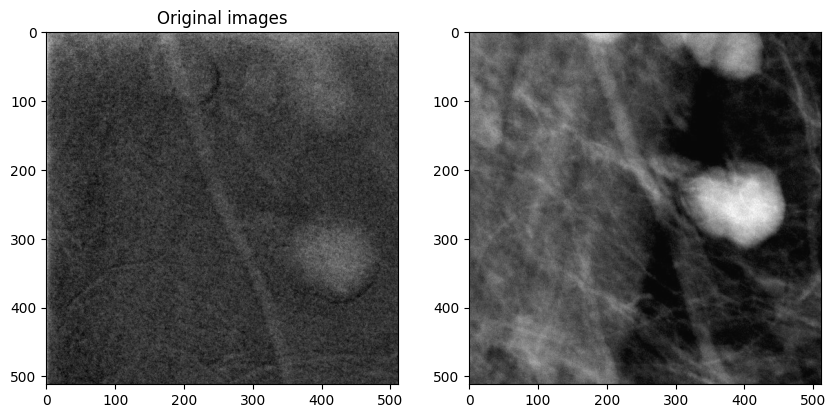

In [70]:
# show first original images on top of each other
fig, ax = plt.subplots(1,2, figsize=(10,5))
# ax[0].imshow(ex_im, cmap='gray')
ax[0].imshow(ex_im[0:512, 0:512], cmap='gray', alpha=0.99)
ax[0].set_title('Original images')
# show registered images
# ax[1].imshow(ex_im, cmap='gray')
ax[1].imshow(sitk.GetArrayFromImage(moved_im)[0:512, 0:512], cmap='gray', alpha=0.99)
